<a href="https://colab.research.google.com/github/carson-edmonds/AAI-520-Chatbot-Project/blob/main/DATA_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import json
import numpy as np
import spacy
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [2]:
#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

# Load the English model
nlp = spacy.load("en_core_web_sm")

Mounted at /content/drive


In [3]:
def squad_json_to_dataframe(file_path, record_path=['data','paragraphs','qas','answers']):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    """

    file = json.loads(open(file_path).read())
    # parsing different level's in the json file
    js = pd.json_normalize(file, record_path)
    m = pd.json_normalize(file, record_path[:-1])
    r = pd.json_normalize(file,record_path[:-2])

    # combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    data = m[['id','question','context','answers']].set_index('id').reset_index()
    data['c_id'] = data['context'].factorize()[0]
    return data

In [4]:
#Load QA dataset
filename = "/content/drive/MyDrive/AAI520/PROJECT/train-v1.1.json"
data = squad_json_to_dataframe(filename)

#Check for null entries and view shape of data
print(data.info(),'\n')

#Preview dataset
data.sample(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87599 entries, 0 to 87598
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        87599 non-null  object
 1   question  87599 non-null  object
 2   context   87599 non-null  object
 3   answers   87599 non-null  object
 4   c_id      87599 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.3+ MB
None 



,id,question,context,answers,c_id
36258,571ddd93b64a571400c71dac,What was it once considered socially advantage...,After a lengthy period of formal racial segreg...,"[{'answer_start': 347, 'text': 'try to ""pass"" ...",7988
61402,572800063acd2414000df1d1,What was Nasser's reaction to the attack?,Nasser made secret contacts with Israel in 195...,"[{'answer_start': 400, 'text': 'did not retali...",13294
87369,57359fece853931400426a85,"In the waning years of the Malla dynasty, what...","During the later part of the Malla era, Kathma...","[{'answer_start': 90, 'text': 'Kantipur, Lalit...",18842
5387,5733dc134776f41900661391,What are feminist anthropologists centrally co...,Feminist anthropology is a four field approach...,"[{'answer_start': 771, 'text': 'gender'}]",903
21022,56f8af2b9e9bad19000a030d,"What does a ""weak"" promoter sequence do?","Firstly, flanking the open reading frame, all ...","[{'answer_start': 615, 'text': 'bind poorly an...",4698
10235,56dde02666d3e219004dad6e,What does CF stand for in this context?,The Canadian Armed Forces (CAF; French: Forces...,"[{'answer_start': 110, 'text': 'Forces canadie...",1944
40668,5726151f38643c19005acfc6,What did Queen Victoria do in response to his ...,"Widowed in 1861, the grief-stricken Queen with...","[{'answer_start': 72, 'text': 'left Buckingham...",8787


In [5]:
#Number of unique documents
print('Number of unique documents:' ,data['c_id'].unique().size)

#Create dataset of documents
documents = data[['context', 'c_id']].drop_duplicates().reset_index(drop=True)
documents.sample(7)

Number of unique documents: 18891


,context,c_id
4362,A treaty breach does not automatically suspend...,4362
8168,"Victoria turned 18 on 24 May 1837, and a regen...",8168
2050,Following the Islamic Conquest of Persia (Iran...,2050
8359,The Bithynians were a Thracian people living i...,8359
14672,"According to conservation of energy, energy ca...",14672
8768,The Dutch written grammar has simplified over ...,8768
11847,"Frederick Lynch, the author of Invisible Victi...",11847


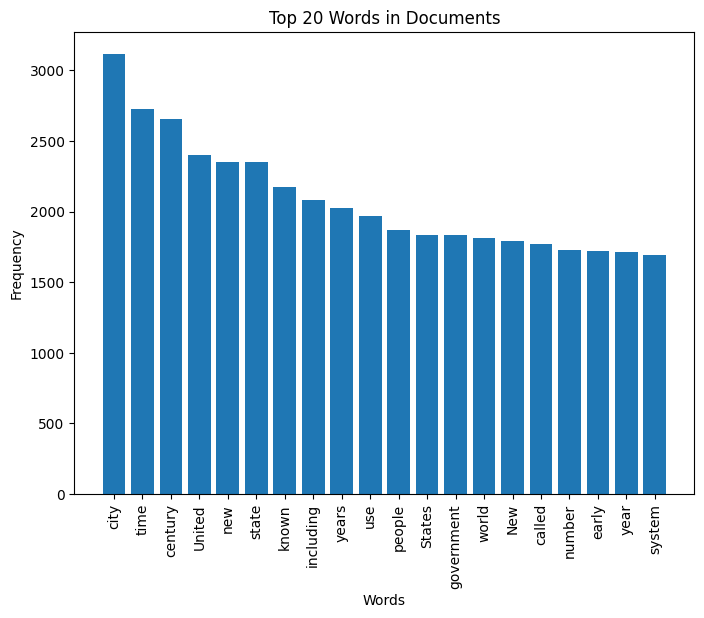

In [6]:
#Find the most common words/topics in the documents
#Tokenize the text and remove stop words and punctuation
context = []
for x in range(0,len(documents)):
  context.append(documents.iloc[x][0])

tokens = []
words = []
for i in context:
  doc = nlp(i)
  sw = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
  text = ' '.join([str(elem) for elem in sw])
  text_low = text.lower()
  tokens.append(text_low)
  for j in sw:
    words.append(j)

all = ' '.join([str(elem) for elem in tokens])

#Identify most frequent words
word_freq = Counter(words)
common_words = word_freq.most_common(20)

#Plot results
pairs = pd.DataFrame(common_words, columns=['Word','Frequency'])
fig, ax = plt.subplots(figsize=(8,6))
plt.bar(pairs['Word'], pairs['Frequency'])
ax.set_title('Top 20 Words in Documents')
ax.set_ylabel('Frequency')
ax.set_xlabel('Words')
plt.xticks(rotation=90)
plt.show()

In [10]:
#Keyword extraction using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_tokens = vectorizer.fit_transform(tokens)

#create dictionary with tfidf values for every phrase
dict_of_tokens={i[1]:i[0] for i in vectorizer.vocabulary_.items()}
tfidf_vectors = []
for row in tfidf_tokens:
  tfidf_vectors.append({dict_of_tokens[column]:value for (column,value) in zip(row.indices,row.data)})

#Sort keywords in descending order
doc_sorted_tfidfs =[]
for dn in tfidf_vectors:
  newD = sorted(dn.items(), key=lambda x: x[1], reverse=True)
  newD = dict(newD)
  doc_sorted_tfidfs.append(newD)

print('Keywords from first 5 documents:')
for i in range(0,5):
  print( doc_sorted_tfidfs[i])

Keywords from first 5 documents:
{'statue': 0.3317257016544204, 'grotto': 0.27464253259183113, 'main': 0.2657240122689653, 'mary': 0.26257809708169516, 'dome': 0.2202960063700482, 'basilica': 0.21786820108359617, 'building': 0.21147102580364913, 'virgin': 0.19844085160985522, 'gold': 0.17524223069703007, 'immediately': 0.17505206472113008, 'venite': 0.15398247629063588, 'upraised': 0.15398247629063588, 'soubirous': 0.14783331941208674, 'bernadette': 0.14783331941208674, 'omnes': 0.14783331941208674, 'lourdes': 0.14008629794142094, 'reputedly': 0.13732126629591557, 'replica': 0.12957424482524976, 'architecturally': 0.1268092131797444, 'marian': 0.12152690290920752, 'reflection': 0.11451089942264617, '1858': 0.11395935911785054, 'statues': 0.11291303483052947, 'atop': 0.11291303483052947, 'legend': 0.10745334608297101, 'connects': 0.10710469424758737, 'prayer': 0.10215030349628634, 'sacred': 0.10166104536075232, 'facing': 0.10050279667686515, 'copper': 0.09266682664095163, 'golden': 0.09

In [8]:
#Apply NER to documents
#Plot the frequency of each entity in the context
# nlp.max_length = 9647555
# doc = nlp(all)
# labels = [x.label_ for x in doc.ents]
# ent_freq = Counter(labels)
# common_ents = ent_freq.most_common()

# pairs = pd.DataFrame(common_ents, columns=['Entity','Frequency'])
# fig, ax = plt.subplots(figsize=(8,6))
# plt.bar(pairs['Entity'], pairs['Frequency'])
# ax.set_title('Named Entity Frequency in Documents')
# ax.set_ylabel('Frequency')
# ax.set_xlabel('Entity')
# plt.xticks(rotation=90)
# plt.show()

In [9]:
#Apply POS tagging to documents
#Plot the frequency of each POS tag in the context
# nlp.max_length = 9647555
# doc = nlp(all)
# tags = [x.pos_ for x in doc]
# tag_freq = Counter(tags)
# common_tag = tag_freq.most_common(10)

# pairs = pd.DataFrame(common_tag, columns=['Tag','Frequency'])
# fig, ax = plt.subplots(figsize=(8,6))
# plt.bar(pairs['Tag'], pairs['Frequency'])
# ax.set_title('POS Tagging Frequency in Documents')
# ax.set_ylabel('Frequency')
# ax.set_xlabel('POS Tag')
# plt.xticks(rotation=90)
# plt.show()